In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


Load Nifty 500 Data from 1990 to 2025

In [3]:
# Load the data
df = pd.read_csv('NIFTY 500_Historical_PR_01011990to28042025.csv')

# Preview data
df.head()


,Index Name,Date,Open,High,Low,Close
0,NIFTY 500,25 Apr 2025,22220.3,22271.85,21661.6,21848.15
1,NIFTY 500,24 Apr 2025,22217.65,22270.15,22155.4,22180.65
2,NIFTY 500,23 Apr 2025,22238.6,22263.85,21988.35,22237.60
3,NIFTY 500,22 Apr 2025,22072,22157.95,21953.4,22085.15
4,NIFTY 500,21 Apr 2025,21787.05,22033.75,21732.45,22005.75


Check for Missing Values and Drop Them

In [4]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Sort by date
df = df.sort_index()

# Check for missing values
print(df.isnull().sum())

# Drop or fill missing values
df = df.dropna()


Index Name    0
Open          0
High          0
Low           0
Close         0
dtype: int64


Plot Closing Price

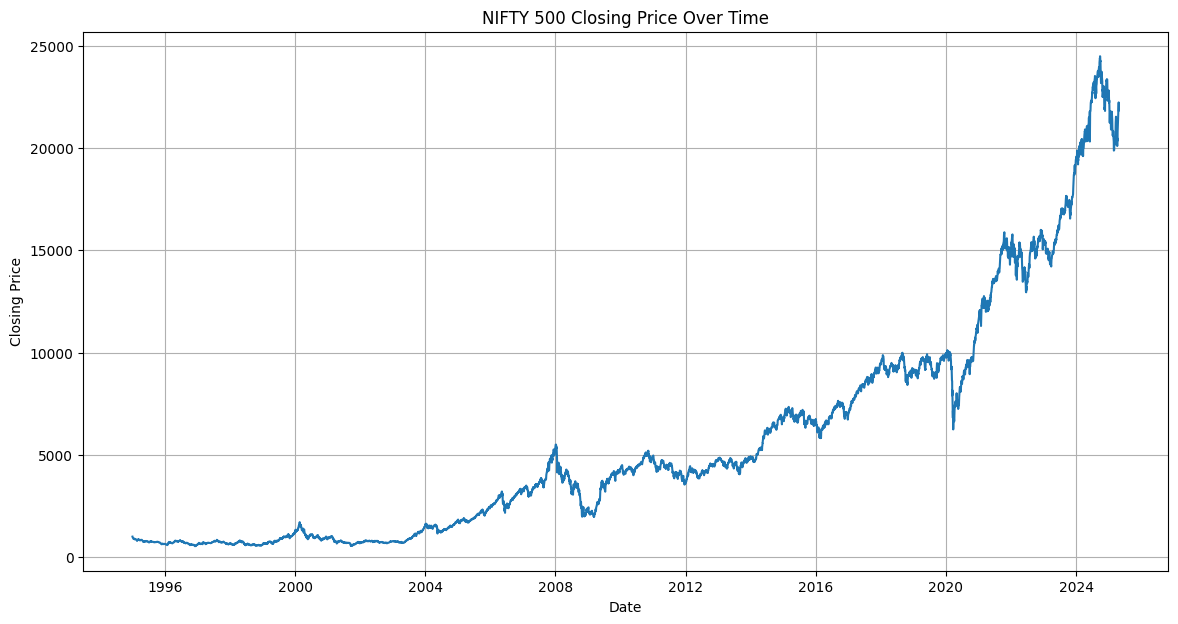

In [5]:
plt.figure(figsize=(14,7))
plt.plot(df['Close'])
plt.title('NIFTY 500 Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid()
plt.show()


Calculate Moving Averages 20 DMA and 100 DMA

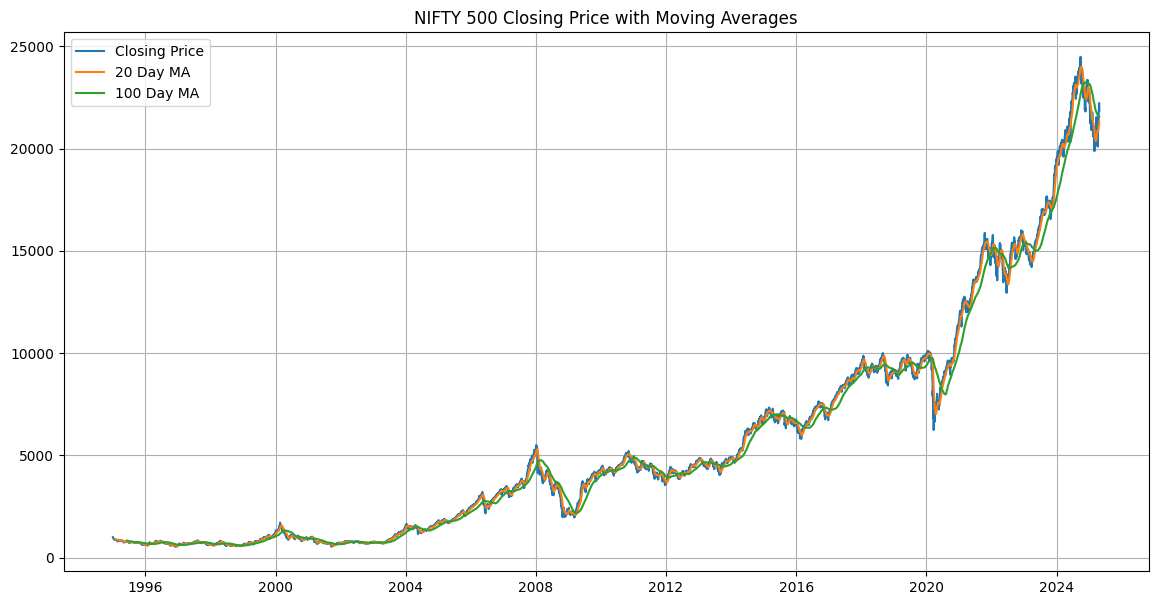

In [6]:
df['MA20'] = df['Close'].rolling(20).mean()
df['MA100'] = df['Close'].rolling(100).mean()

plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Closing Price')
plt.plot(df['MA20'], label='20 Day MA')
plt.plot(df['MA100'], label='100 Day MA')
plt.title('NIFTY 500 Closing Price with Moving Averages')
plt.legend()
plt.grid()
plt.show()


Calculate Daily Returns

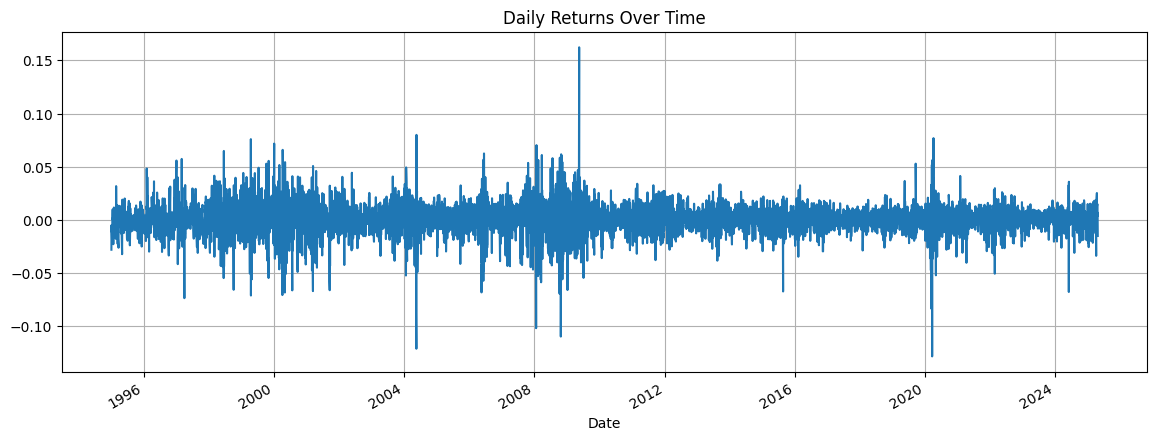

In [7]:
df['Daily Return'] = df['Close'].pct_change()

plt.figure(figsize=(14,5))
df['Daily Return'].plot()
plt.title('Daily Returns Over Time')
plt.grid()
plt.show()


**Periods of high volatility** are clearly visible, such as during the **2008 financial crisis** and the **2020 COVID-19 recession**, where return values sharply spiked or dropped.

Distribution of Daily Returns

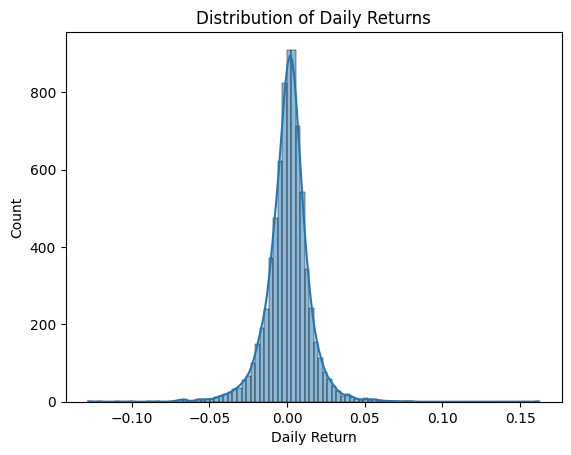

In [8]:
sns.histplot(df['Daily Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.show()


The distribution is **centered around 0**, indicating that on most days, the market experiences relatively small positive or negative returns.
he fatter tails suggest the presence of **extreme events** — large gains or losses — more frequently than what would be expected under a normal distribution.


Prepare Data for Keras Model
Scaling the Data

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])


Create Sequences
Let's take the last 60 days to predict the next day.

In [10]:
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for LSTM: [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


Build and Train LSTM Model

In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


c:\Users\shoun\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.8218e-05 - val_loss: 6.0100e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.7771e-05 - val_loss: 8.6786e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.6363e-05 - val_loss: 9.7504e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.6718e-05 - val_loss: 5.5368e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.3473e-05 - val_loss: 5.8538e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.1424e-05 - val_loss: 8.4721e-04
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.0335e-05 - val_loss: 3.0696e-04
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.8491e-05 - val_loss: 1.6857e-04
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.0147e-05 - val_loss: 5.5744e-04
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.7599

Plotting Training and Validation Loss

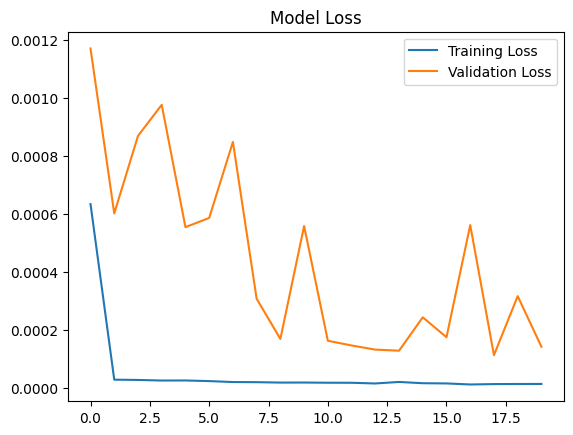

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()



The **Training Loss** decreases rapidly and stabilizes very close to zero, indicating that the model fits the training data well.
The **Validation Loss** shows more fluctuation but follows a general downward trend, suggesting that the model is learning, although with some noise.
The fluctuations in validation loss could be due to the volatile nature of financial time series data, where daily returns are noisy and hard to predict precisely.
There is **no clear sign of overfitting** (where validation loss would increase while training loss decreases sharply), which means the model generalizes reasonably to unseen data.
However, further smoothing of validation loss could be achieved by techniques like model regularization, more data, or hyperparameter tuning.
Overall, the model training appears to be successful, with both training and validation errors kept low.
